# 生データを用いたHAR
### なにゆえ？
原論文では生データを用いた学習＆推定でいい感じに学習していた。（検証データのみだが）  
CNNのプーリングによってノイズを取り除いた特徴を捉えている可能性が高い。また、CMNによって取り除いた特徴量に何かしら重要な情報があるかもしれない。　　

ノイズによって過学習が抑制できるかもしれない。

## DataLoaderの定義

In [72]:
import torch
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from cutill.x64.Release import cutill as c

# 自作モジュール
import utills.datapath as dpath
import utills.preprocess as pp

class dataset(Dataset):
    def __init__(self, paths, transforms=None):
        self.transforms = transforms

        # データを格納する配列を確保
        self.train_wave = np.empty(((0, 2, 1280)))
        self.train_posture = np.empty(0)  # 姿勢データ配列

        # データ読み込みと前処理
        for p in paths:
            left, right, posture = pp.slicer(p)  # leftとrightが返されることを仮定
            for l, r in zip(left, right):
                l, r = c.normalize(l, r)
                wave = np.stack([l, r], axis=0)  # 2つのチャンネル（lとr）を新しい軸で結合
                self.train_wave = np.vstack((self.train_wave, [wave])) if self.train_wave.size else np.array([wave])
            self.train_posture = np.append(self.train_posture, posture) if self.train_posture.size else posture

    def __len__(self):
        return len(self.train_posture)

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        wave = torch.tensor(self.train_wave[idx], dtype=torch.float32)
        posture = torch.tensor(self.train_posture[idx]-1, dtype=torch.long)
        if self.transforms is not None:
            wave = self.transforms(wave)
            posture = self.transforms(posture)
        return wave, posture

## 学習&検証

In [73]:
import random
import os

def seed_everything(seed=0):
    random.seed(seed)  # Python標準のrandomモジュールのシードを設定
    os.environ['PYTHONHASHSEED'] = str(seed)  # ハッシュ生成のためのシードを環境変数に設定
    np.random.seed(seed)  # NumPyの乱数生成器のシードを設定
    torch.manual_seed(seed)  # PyTorchの乱数生成器のシードをCPU用に設定
    torch.cuda.manual_seed(seed)  # PyTorchの乱数生成器のシードをGPU用に設定
    torch.backends.cudnn.deterministic = True  # PyTorchの畳み込み演算の再現性を確保

seed_everything()  # 上述のシード設定関数を呼び出し

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [74]:
# 被験者
identity = dpath.LMH.M004.value.st_center
# バッチサイズ
batch_size = 128
# データの形
concat = False

# 訓練データのパスを取得
type, tester, mattress, position = dpath.getattributes(identity)

train_paths = []
for mat in dpath.mattress_all():
    if mat == mattress:
        continue
    train_paths.extend(eval(f"dpath.{type}.serch('{mat}', skip=[dpath.{type}.{tester}])"))
    train_paths.extend(dpath.YMGT.serch('ka'))
train_paths = dpath.extract_position(train_paths, position=position)

test_path = [identity.value]

print("--- train ---")
train_val = dataset(train_paths)
print("--- test ---")
test = dataset(test_path)

n_samples = len(train_val)
train_size = int(n_samples * 0.8)    # [train : val] を [8 : 2] に分割
val_size = n_samples - train_size

train, val = torch.utils.data.random_split(train_val, [train_size, val_size])

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

test_loader = DataLoader(
    test,
    shuffle=False,
)

--- train ---
raw\LMH\M003\flf_center | data[37 / 178]
raw\LMH\M001\fls_center | data[190 / 352]
raw\LMH\M001\fld_center | data[226 / 444]
raw\LMH\H003\fl_center | data[204 / 223]
raw\LMH\H003\ka_center | data[204 / 215]
raw\LMH\M003\ka_center | data[208 / 370]
raw\YMGT\YMGT_1\ka_center | data[169 / 178]
raw\YMGT\YMGT_3\ka_center | data[288 / 463]
raw\YMGT\YMGT_2\ka_center | data[332 / 403]
raw\LMH\M002\fls_center | data[238 / 427]
raw\LMH\L003\fl_center | data[186 / 223]
raw\LMH\M002\fld_center | data[232 / 389]
raw\YMGT\YMGT_7\ka_center | data[161 / 223]
raw\LMH\L001\fl_center | data[171 / 238]
raw\YMGT\YMGT_11\ka_center | data[178 / 208]
raw\LMH\L003\ka_center | data[217 / 283]
raw\LMH\L001\ka_center | data[206 / 223]
raw\LMH\M001\flf_center | data[89 / 297]
raw\YMGT\YMGT_4\ka_center | data[152 / 178]
raw\LMH\H002\fl_center | data[212 / 238]
raw\LMH\M003\fls_center | data[348 / 642]
raw\LMH\M003\fld_center | data[171 / 312]
raw\LMH\H002\ka_center | data[168 / 223]
raw\LMH\M001\ka_ce

### 学習

In [75]:
import torch.optim as optim
import torch.nn as nn
import model.har as har
from torcheval.metrics import MulticlassConfusionMatrix

# モデルのインスタンス化
# left, right の 2ch 入力
num_channel = 2
net = har.HAR_resnet18(num_classes=4, num_channel=num_channel).to(device)

# 誤差関数を交差エントロピーで計算
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム
lr = 5e-4
optimizer = optim.Adam(net.parameters(), lr=lr)

confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)

train_accuracy, val_accuracy, test_accuracy = [], [], []
train_error, val_error, test_error = [], [], []

# 学習
n_epoch = 200
for epoch in range(n_epoch):
    # 精度と損失の初期化
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_val = 0, 0
    test_loss, test_acc = 0, 0
    n_test = 0

    # 学習
    for train_input, train_label in train_loader:
        n_train += len(train_label)

        # 入力と正解ラベルをGPU上に移動
        input = train_input.to(device)
        label = train_label.to(device)
        # print(f'input : {input.shape}, label : {label.shape}')

        # モデルを学習モードに変更
        net.train()

        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == label).sum().item()

    # 検証
    for val_input, val_label in val_loader:
        n_val += len(val_label)

        val_input = val_input.to(device)
        val_label = val_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            val_output = net(val_input)
        loss = criterion(val_output, val_label)

        val_predicted = torch.max(val_output, 1)[1]
        
        val_loss += loss.item()
        val_acc += (val_predicted == val_label).sum().item()
        if epoch+1 == n_epoch:
            confusion_mat.update(val_predicted, val_label)

    # テスト
    for test_input, test_label in test_loader:
        n_test += len(test_label)

        test_input = test_input.to(device)
        test_label = test_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            test_output = net(test_input)
        loss = criterion(test_output, test_label)

        test_predicted = torch.max(test_output, 1)[1]

        test_loss += loss.item()
        test_acc += (test_predicted == test_label).sum().item()
        
    # 精度を確率に変換
    test_acc /= n_test
    test_loss = test_loss / n_test

    print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}")

    # 精度を確率に変換
    train_acc /= n_train
    val_acc /= n_val
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val

    train_accuracy.append(train_acc*100)
    val_accuracy.append(val_acc*100)
    test_accuracy.append(test_acc*100)
    train_error.append(train_loss)
    val_error.append(val_loss)
    test_error.append(test_loss)

    if epoch+1 == n_epoch:
        confusion_mat.compute()

    if not epoch%1:
        print(f"Epoch[{epoch+1}/{n_epoch}] | train_loss: {train_loss:.5f} | train_acc: {train_acc:.5f} | val_loss: {val_loss:.5f} | val_acc: {val_acc:.5f}")



loss : 1.15544, acc : 0.47126
Epoch[1/200] | train_loss: 1.28954 | train_acc: 0.39556 | val_loss: 1.16327 | val_acc: 0.47569
loss : 1.09420, acc : 0.43678
Epoch[2/200] | train_loss: 1.18387 | train_acc: 0.47780 | val_loss: 1.10097 | val_acc: 0.51823
loss : 1.28277, acc : 0.43678
Epoch[3/200] | train_loss: 1.17051 | train_acc: 0.47821 | val_loss: 1.09234 | val_acc: 0.53385
loss : 1.25354, acc : 0.43678
Epoch[4/200] | train_loss: 1.15047 | train_acc: 0.50185 | val_loss: 1.06019 | val_acc: 0.56250
loss : 1.20638, acc : 0.43678
Epoch[5/200] | train_loss: 1.13102 | train_acc: 0.50946 | val_loss: 1.04428 | val_acc: 0.56944
loss : 1.14811, acc : 0.48276
Epoch[6/200] | train_loss: 1.11898 | train_acc: 0.51624 | val_loss: 1.04386 | val_acc: 0.56858
loss : 1.28396, acc : 0.44828
Epoch[7/200] | train_loss: 1.11597 | train_acc: 0.51994 | val_loss: 1.03518 | val_acc: 0.54774
loss : 1.21705, acc : 0.43678
Epoch[8/200] | train_loss: 1.10380 | train_acc: 0.52179 | val_loss: 1.00006 | val_acc: 0.60243


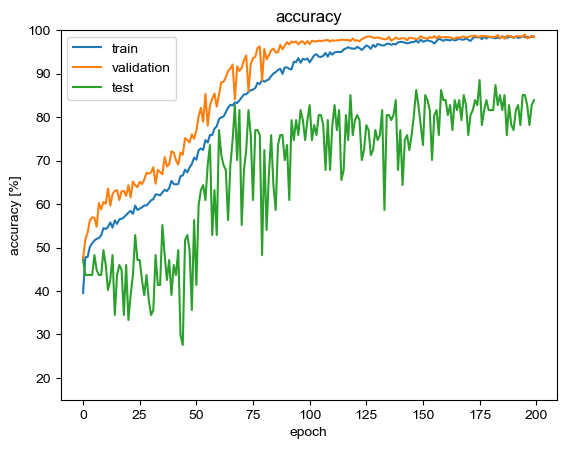

In [79]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_accuracy, label="train")
plt.plot(x, val_accuracy, label="validation")
plt.plot(x, test_accuracy, label="test")

# グラフのタイトルと軸ラベルの作成
plt.ylim(15, 100)
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy [%]")
plt.legend()
plt.savefig("../images/accuracy.jpg")

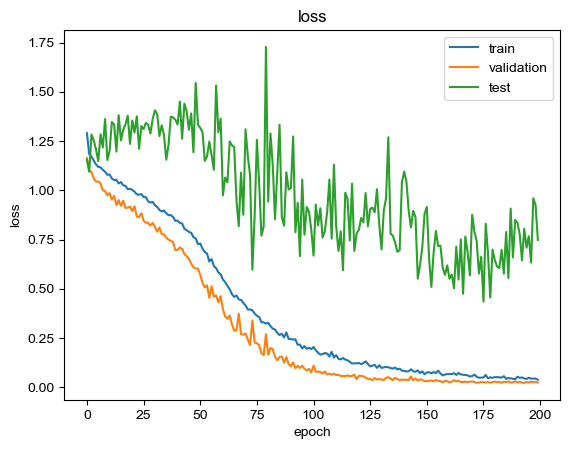

In [77]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_error, label="train")
plt.plot(x, val_error, label="validation")
plt.plot(x, test_error, label="test")

# グラフのタイトルと軸ラベルの作成
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("../images/loss.jpg")

### 推定

loss : 9.67623, acc : 0.83908, recall : 0.83908, precision : 0.83908, f1_score : 0.83908
tensor([[33.,  3.,  0.,  0.],
        [ 0., 38.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 11.,  0.,  2.]])


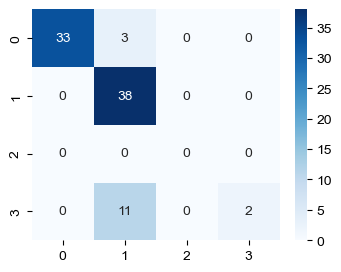

In [78]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassF1Score
from torcheval.metrics import MulticlassConfusionMatrix

accuracy = MulticlassAccuracy(
        average = "micro",
        num_classes = 4
)
recall = MulticlassRecall(
        average = "micro",
        num_classes = 4
)
precision = MulticlassPrecision(
        average = "micro",
        num_classes = 4
)
f1_score = MulticlassF1Score(
        average = "micro",
        num_classes = 4 
)
confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)
loss = 0
n = 0

for input, label in test_loader:
        n += len(test_label)

        input = input.to(device)
        label = label.to(device)

        output = net(input)
        test_loss = criterion(output, label)

        predicted = torch.max(output, 1)[1]

        loss += test_loss.item()
        accuracy.update(predicted, label)
        recall.update(predicted, label)
        precision.update(predicted, label)
        f1_score.update(predicted, label)
        confusion_mat.update(predicted, label)
        
# 精度を確率に変換
acc = accuracy.compute().item()
recall = recall.compute().item()
precision = precision.compute().item()
f1_score = f1_score.compute().item()
confusion_mat = confusion_mat.compute()
test_loss = test_loss * batch_size / n_test

print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}, recall : {recall:.5f}, precision : {precision:.5f}, f1_score : {f1_score:.5f}")
print(confusion_mat)

import utills.record_utillities as ru
confusion_mat = confusion_mat.to('cpu').detach().numpy().copy()
ru.save_confusion_matrix(confusion_mat)